# Hungarian algorithm for BP pairings
_Chuan-Zheng Lee <czlee@stanford.edu>_

This notebook does a very simple trial of using the Hungarian algorithm to generate pairings for a BP tournament.

The traditional Hungarian algorithm doesn't try to choose randomly; it simply chooses whichever optimal solution it happens to come across first. There are two ideas to "randomise" the Hungarian algorithm in this notebook:

1. Shuffle the rows and columns of the cost matrix first, then run the Hungarian algorithm on this shuffled matrix
2. Pass in the cost matrix as-is, but during the algorithm, in stages where we are looking for the first row or column, search throw the rows or columns in random order.

We try this for two situations, both involving an eight-team bracket:

1. A "BP-like" cost matrix, which is generated assuming that teams have so far had three rounds, and intentionally ensuring that the same positions in both rooms are of the same cost.
2. A Bernoulli i.i.d. cost matrix, with parameter p = 2/3.

It doesn't appear that the two methods of randomisation are any different to each other.

In [1]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from munkres import Munkres
niterations = 160000

# Check if this is the modified randomized version of the Munkres library,
# available at https://github.com/czlee/munkres/.
try:
    Munkres(random=True)
except TypeError:
    randomized_munkres = False
else:
    randomized_munkres = True

In [2]:
def hungarian_shuffle_first(costs):
    """Applies the Hungarian algorithm to `costs`, but permutes the rows and
    columns of the matrix first. Returns a list of column numbers."""
    n = len(costs)
    I = random.sample(range(n), n)
    J = random.sample(range(n), n)
    C = [[costs[i][j] for j in J] for i in I]
    m = Munkres()
    indices = m.compute(C)
    cols = [0] * n
    for i, j in indices:
        cols[I[i]] = J[j]
    return cols

def hungarian_shuffle_during(costs):
    """Applies a randomized version of the Hungarian algorithm.
    This only works with a modified version of the Munkres library, which
    can be cloned from https://github.com/czlee/munkres/.
    Randomizing during the algorithm seemed to have much the same effect as
    shuffling before it, so won't be pushing these changes into a pull
    request."""
    m = Munkres(random=True)
    indices = m.compute(costs)
    cols = [0] * len(costs)
    for i, j in indices:
        cols[i] = j
    return cols

def shuffle_hungarian_shuffle_positions(costs):
    cols = hungarian_shuffle_first(costs)
    positions = [col % 4 for col in cols]
    final = [None] * len(cols)
    for pos in range(4):
        rows = [i for i, j in enumerate(positions) if j == pos]
        random.shuffle(rows)
        for i, row in enumerate(rows):
            final[row] = 4 * i + pos
    assert None not in final
    return final

def total_cost(costs, cols):
    """Computes the total cost according to `costs`, of the chosen columns
    `cols`."""
    rows = range(len(costs))
    return sum(costs[i][j] for i, j in zip(rows, cols))

def generate_bp_costs(d, k):
    """Generates an `4d`-by-`4d` cost matrix that assumes there have been
    `k` debates before now. (`d` represents the number of BP debates.)"""
    costs = []
    for i in range(4 * d):
        history = [random.choice(range(4)) for i in range(k)]
        counts = [history.count(pos) for pos in range(4)]
        row = counts * d  # replicate list `d` times
        costs.append(row)
    return costs
        
def run_simulations(costs, niterations, allocate):
    """Runs the Munkres-shuffle-first algorithm on the matrix `costs`
    `niterations` times, and returns a dict mapping solutions to
    frequencies (how many iterations that solution was obtained)."""
    results = Counter()
    for i in range(niterations):
        results[tuple(allocate(costs))] += 1
    return results

def verify_costs(costs, solutions):
    """Verifies that every key in solutions gives the same cost, and
    returns that cost if so."""
    total_costs = [total_cost(costs, solution) for solution in solutions]
    assert len(set(total_costs)) == 1
    return total_costs[0]

def frequencies_by_position(results):
    """Converts a sequence of solutions into just the positions (0 to 3,
    representing the 4 BP positions), and returns a dict mapping each such
    sequence to a list of frequencies for solutions that reduce to that 
    sequence of positions. Useful only for results of cost matrices generated 
    by `generate_bp_costs`."""
    reduced = {}
    for solution, frequency in results.items():
        positions = tuple(x % 4 for x in solution)
        frequencies = reduced.setdefault(positions, [])
        frequencies.append(frequency)
    return reduced

def plot_by_group(grouped):
    grouped_values = [v for k, v in sorted(grouped.items())]
    grouped_freqs = sum(grouped.values(), [])
    xpos = []
    x = 1
    for group in grouped.values():
        xpos.extend(range(x, x + len(group)))
        x += len(group) + 1
    plt.figure(figsize=(14, 7))
    plt.bar(xpos, grouped_freqs, width=1)
    plt.xlim(0, x)
    plt.show()

## British Parliamentary-like simulation

In [3]:
# costs = generate_bp_costs(2, 3)
# Different randomly generated matrices can have very different results;
# The below matrix is a good illustration of what can happen (in a bad way).
costs = [[1, 1, 1, 0, 1, 1, 1, 0],
         [1, 1, 1, 0, 1, 1, 1, 0],
         [0, 0, 2, 1, 0, 0, 2, 1],
         [0, 0, 1, 2, 0, 0, 1, 2],
         [1, 1, 0, 1, 1, 1, 0, 1],
         [0, 1, 1, 1, 0, 1, 1, 1],
         [1, 1, 1, 0, 1, 1, 1, 0],
         [0, 1, 0, 2, 0, 1, 0, 2]]

### Hungarian, shuffle first

In [4]:
results = run_simulations(costs, niterations, hungarian_shuffle_first)
results

Counter({(0, 3, 1, 5, 2, 4, 7, 6): 1130,
         (0, 3, 1, 5, 6, 4, 7, 2): 1106,
         (0, 3, 5, 1, 2, 4, 7, 6): 1123,
         (0, 3, 5, 1, 6, 4, 7, 2): 1159,
         (0, 7, 1, 5, 2, 4, 3, 6): 1139,
         (0, 7, 1, 5, 6, 4, 3, 2): 1100,
         (0, 7, 5, 1, 2, 4, 3, 6): 1100,
         (0, 7, 5, 1, 6, 4, 3, 2): 1128,
         (1, 3, 0, 5, 2, 4, 7, 6): 543,
         (1, 3, 0, 5, 6, 4, 7, 2): 559,
         (1, 3, 4, 5, 2, 0, 7, 6): 572,
         (1, 3, 4, 5, 6, 0, 7, 2): 535,
         (1, 3, 5, 0, 2, 4, 7, 6): 563,
         (1, 3, 5, 0, 6, 4, 7, 2): 554,
         (1, 3, 5, 4, 2, 0, 7, 6): 581,
         (1, 3, 5, 4, 6, 0, 7, 2): 554,
         (1, 7, 0, 5, 2, 4, 3, 6): 560,
         (1, 7, 0, 5, 6, 4, 3, 2): 547,
         (1, 7, 4, 5, 2, 0, 3, 6): 495,
         (1, 7, 4, 5, 6, 0, 3, 2): 546,
         (1, 7, 5, 0, 2, 4, 3, 6): 569,
         (1, 7, 5, 0, 6, 4, 3, 2): 551,
         (1, 7, 5, 4, 2, 0, 3, 6): 583,
         (1, 7, 5, 4, 6, 0, 3, 2): 506,
         (2, 3, 1, 5, 6, 0, 7, 4

In [5]:
grouped = frequencies_by_position(results)
grouped

{(0, 3, 1, 1, 2, 0, 3, 2): [1100,
  1159,
  1061,
  1106,
  1051,
  1123,
  1130,
  1113,
  1113,
  1162,
  1150,
  1100,
  1065,
  1128,
  1107,
  1139],
 (1, 3, 0, 1, 2, 0, 3, 2): [543,
  547,
  546,
  559,
  517,
  521,
  563,
  558,
  566,
  495,
  603,
  579,
  572,
  535,
  532,
  560],
 (1, 3, 1, 0, 2, 0, 3, 2): [555,
  528,
  538,
  554,
  583,
  569,
  554,
  581,
  551,
  573,
  563,
  528,
  569,
  521,
  561,
  506],
 (2, 3, 1, 1, 2, 0, 3, 0): [1077,
  1136,
  1106,
  1094,
  1116,
  1087,
  1155,
  1121,
  1131,
  1094,
  1115,
  1144,
  1099,
  1096,
  1107,
  1133],
 (3, 0, 1, 1, 2, 0, 3, 2): [1131,
  1058,
  1133,
  1074,
  1099,
  1098,
  1100,
  1159,
  1100,
  1141,
  1089,
  1130,
  1108,
  1125,
  1099,
  1127],
 (3, 1, 0, 1, 2, 0, 3, 2): [530,
  535,
  503,
  557,
  584,
  590,
  536,
  529,
  536,
  597,
  572,
  596,
  534,
  555,
  547,
  551],
 (3, 1, 1, 0, 2, 0, 3, 2): [527,
  580,
  546,
  550,
  507,
  547,
  532,
  523,
  542,
  562,
  549,
  506,
  566,
 

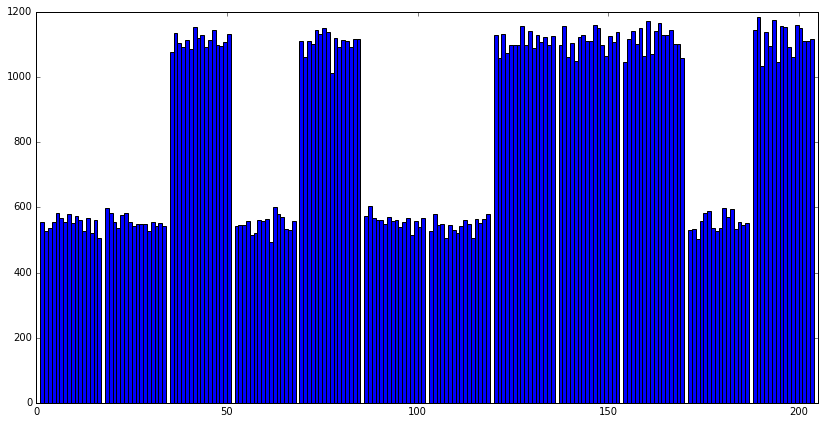

In [6]:
plot_by_group(grouped)

In [7]:
verify_costs(costs, results)

1

### Hungarian, shuffle first then shuffle positions after

In [8]:
results = run_simulations(costs, niterations, shuffle_hungarian_shuffle_positions)
results

Counter({(0, 3, 1, 5, 2, 4, 7, 6): 1056,
         (0, 3, 1, 5, 6, 4, 7, 2): 1060,
         (0, 3, 5, 1, 2, 4, 7, 6): 1092,
         (0, 3, 5, 1, 6, 4, 7, 2): 1077,
         (0, 7, 1, 5, 2, 4, 3, 6): 1123,
         (0, 7, 1, 5, 6, 4, 3, 2): 1097,
         (0, 7, 5, 1, 2, 4, 3, 6): 1101,
         (0, 7, 5, 1, 6, 4, 3, 2): 1193,
         (1, 3, 0, 5, 2, 4, 7, 6): 610,
         (1, 3, 0, 5, 6, 4, 7, 2): 553,
         (1, 3, 4, 5, 2, 0, 7, 6): 567,
         (1, 3, 4, 5, 6, 0, 7, 2): 595,
         (1, 3, 5, 0, 2, 4, 7, 6): 581,
         (1, 3, 5, 0, 6, 4, 7, 2): 578,
         (1, 3, 5, 4, 2, 0, 7, 6): 580,
         (1, 3, 5, 4, 6, 0, 7, 2): 541,
         (1, 7, 0, 5, 2, 4, 3, 6): 584,
         (1, 7, 0, 5, 6, 4, 3, 2): 512,
         (1, 7, 4, 5, 2, 0, 3, 6): 520,
         (1, 7, 4, 5, 6, 0, 3, 2): 490,
         (1, 7, 5, 0, 2, 4, 3, 6): 577,
         (1, 7, 5, 0, 6, 4, 3, 2): 518,
         (1, 7, 5, 4, 2, 0, 3, 6): 571,
         (1, 7, 5, 4, 6, 0, 3, 2): 509,
         (2, 3, 1, 5, 6, 0, 7, 4

In [9]:
grouped = frequencies_by_position(results)
grouped

{(0, 3, 1, 1, 2, 0, 3, 2): [1101,
  1077,
  1060,
  1146,
  1164,
  1086,
  1092,
  1056,
  1124,
  1114,
  1142,
  1112,
  1097,
  1112,
  1193,
  1123],
 (1, 3, 0, 1, 2, 0, 3, 2): [559,
  520,
  553,
  521,
  512,
  537,
  572,
  591,
  610,
  512,
  567,
  595,
  572,
  490,
  580,
  584],
 (1, 3, 1, 0, 2, 0, 3, 2): [582,
  585,
  578,
  543,
  571,
  541,
  539,
  518,
  614,
  539,
  580,
  577,
  566,
  545,
  509,
  581],
 (2, 3, 1, 1, 2, 0, 3, 0): [1135,
  1080,
  1129,
  1155,
  1074,
  1100,
  1089,
  1057,
  1088,
  1155,
  1112,
  1104,
  1039,
  1026,
  1122,
  1120],
 (3, 0, 1, 1, 2, 0, 3, 2): [1127,
  1145,
  1129,
  1133,
  1123,
  1122,
  1084,
  1102,
  1085,
  1149,
  1117,
  1114,
  1049,
  1098,
  1119,
  1121],
 (3, 1, 0, 1, 2, 0, 3, 2): [562,
  582,
  557,
  569,
  568,
  560,
  543,
  561,
  574,
  533,
  595,
  553,
  525,
  544,
  537,
  559],
 (3, 1, 1, 0, 2, 0, 3, 2): [582,
  557,
  530,
  550,
  547,
  530,
  535,
  537,
  560,
  536,
  516,
  566,
  571,
 

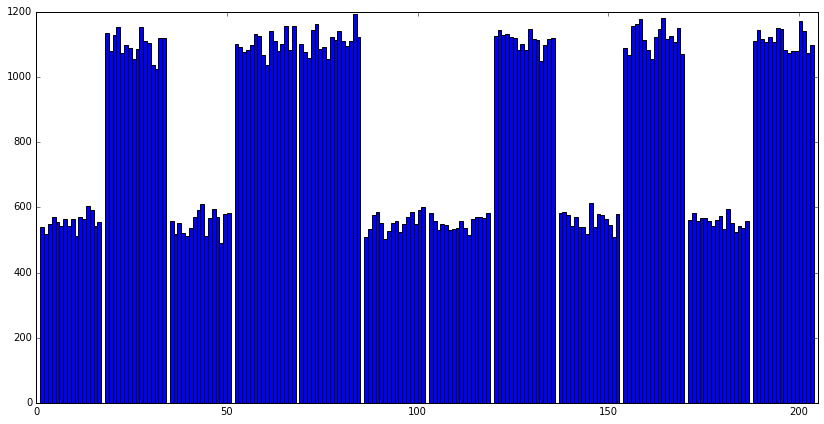

In [10]:
plot_by_group(grouped)

In [11]:
verify_costs(costs, results)

1

### Randomized version of Hungarian

In [12]:
# Only run the next three cells if the randomized version of munkres is available
results = run_simulations(costs, niterations, hungarian_shuffle_during) if randomized_munkres else None
results

Counter({(0, 3, 1, 5, 2, 4, 7, 6): 1076,
         (0, 3, 1, 5, 6, 4, 7, 2): 1136,
         (0, 3, 5, 1, 2, 4, 7, 6): 1145,
         (0, 3, 5, 1, 6, 4, 7, 2): 1023,
         (0, 7, 1, 5, 2, 4, 3, 6): 1123,
         (0, 7, 1, 5, 6, 4, 3, 2): 1087,
         (0, 7, 5, 1, 2, 4, 3, 6): 1148,
         (0, 7, 5, 1, 6, 4, 3, 2): 1180,
         (1, 3, 0, 5, 2, 4, 7, 6): 561,
         (1, 3, 0, 5, 6, 4, 7, 2): 513,
         (1, 3, 4, 5, 2, 0, 7, 6): 539,
         (1, 3, 4, 5, 6, 0, 7, 2): 518,
         (1, 3, 5, 0, 2, 4, 7, 6): 520,
         (1, 3, 5, 0, 6, 4, 7, 2): 549,
         (1, 3, 5, 4, 2, 0, 7, 6): 588,
         (1, 3, 5, 4, 6, 0, 7, 2): 541,
         (1, 7, 0, 5, 2, 4, 3, 6): 523,
         (1, 7, 0, 5, 6, 4, 3, 2): 560,
         (1, 7, 4, 5, 2, 0, 3, 6): 531,
         (1, 7, 4, 5, 6, 0, 3, 2): 568,
         (1, 7, 5, 0, 2, 4, 3, 6): 531,
         (1, 7, 5, 0, 6, 4, 3, 2): 551,
         (1, 7, 5, 4, 2, 0, 3, 6): 558,
         (1, 7, 5, 4, 6, 0, 3, 2): 530,
         (2, 3, 1, 5, 6, 0, 7, 4

In [13]:
grouped = frequencies_by_position(results) if randomized_munkres else None
grouped

{(0, 3, 1, 1, 2, 0, 3, 2): [1148,
  1023,
  1155,
  1136,
  1069,
  1145,
  1076,
  1106,
  1142,
  1083,
  1081,
  1087,
  1108,
  1180,
  1047,
  1123],
 (1, 3, 0, 1, 2, 0, 3, 2): [513,
  568,
  499,
  522,
  523,
  561,
  560,
  560,
  587,
  531,
  544,
  551,
  539,
  518,
  569,
  554],
 (1, 3, 1, 0, 2, 0, 3, 2): [582,
  549,
  515,
  558,
  541,
  531,
  541,
  551,
  537,
  521,
  531,
  588,
  537,
  540,
  530,
  520],
 (2, 3, 1, 1, 2, 0, 3, 0): [1106,
  1165,
  1117,
  1093,
  1096,
  1132,
  1146,
  1112,
  1152,
  1151,
  1118,
  1109,
  1116,
  1164,
  1100,
  1140],
 (3, 0, 1, 1, 2, 0, 3, 2): [1121,
  1106,
  1088,
  1078,
  1155,
  1095,
  1070,
  1151,
  1093,
  1093,
  1082,
  1154,
  1137,
  1126,
  1108,
  1111],
 (3, 1, 0, 1, 2, 0, 3, 2): [580,
  516,
  601,
  565,
  562,
  547,
  582,
  600,
  553,
  568,
  542,
  580,
  582,
  546,
  573,
  551],
 (3, 1, 1, 0, 2, 0, 3, 2): [558,
  570,
  570,
  585,
  563,
  573,
  543,
  548,
  536,
  533,
  499,
  545,
  602,
 

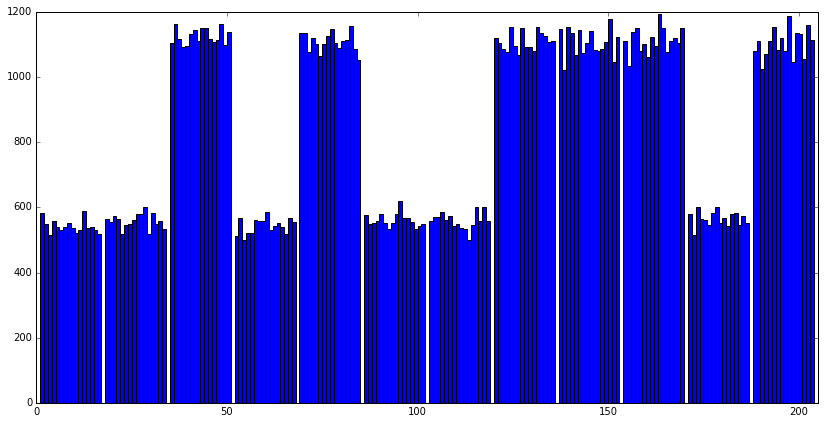

In [14]:
if randomized_munkres:
    plot_by_group(grouped)

In [15]:
verify_costs(costs, results) if randomized_munkres else None

1

## Random (Bernoulli i.i.d.) costs

In [16]:
def generate_random_costs(n, p):
    """Generates an `n`-by-`n` cost matrix in which each elements is
    i.i.d. Bernoulli(p). This is probably not a realistic cost matrix
    for a BP bracket."""
    return [[int(random.random() < p) for i in range(n)] for j in range(n)]

In [17]:
costs = generate_random_costs(8, 2/3)
costs

[[1, 1, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 1, 1, 0]]

### Hungarian, shuffle first

In [18]:
results = run_simulations(costs, niterations, hungarian_shuffle_first)
results

Counter({(2, 0, 4, 5, 6, 3, 1, 7): 5572,
         (2, 5, 4, 1, 6, 3, 0, 7): 4885,
         (2, 5, 4, 1, 6, 3, 7, 0): 4188,
         (2, 7, 4, 5, 6, 3, 1, 0): 4622,
         (3, 0, 4, 5, 6, 2, 1, 7): 4486,
         (3, 5, 4, 1, 6, 2, 0, 7): 4496,
         (3, 5, 4, 1, 6, 2, 7, 0): 3702,
         (3, 7, 4, 5, 6, 2, 1, 0): 3741,
         (5, 0, 4, 1, 6, 2, 3, 7): 3866,
         (5, 0, 4, 1, 6, 2, 7, 3): 4866,
         (5, 0, 4, 1, 6, 3, 2, 7): 5033,
         (5, 0, 4, 3, 6, 2, 1, 7): 4557,
         (5, 0, 4, 6, 3, 2, 1, 7): 5864,
         (5, 2, 4, 1, 6, 3, 0, 7): 5071,
         (5, 2, 4, 1, 6, 3, 7, 0): 4360,
         (5, 3, 4, 1, 6, 2, 0, 7): 4011,
         (5, 3, 4, 1, 6, 2, 7, 0): 3437,
         (5, 7, 4, 1, 6, 2, 0, 3): 4755,
         (5, 7, 4, 1, 6, 2, 3, 0): 3322,
         (5, 7, 4, 1, 6, 3, 2, 0): 4170,
         (5, 7, 4, 3, 6, 2, 1, 0): 3680,
         (5, 7, 4, 6, 3, 2, 1, 0): 4940,
         (6, 0, 4, 5, 3, 2, 1, 7): 5722,
         (6, 5, 4, 1, 3, 2, 0, 7): 5879,
         (6, 5, 

In [19]:
verify_costs(costs, results)

1

### Randomized version of Hungarian

In [20]:
# Only run the next two cells if the randomized version of munkres is available
results = run_simulations(costs, niterations, hungarian_shuffle_during) if randomized_munkres else None
results

Counter({(2, 0, 4, 5, 6, 3, 1, 7): 5603,
         (2, 5, 4, 1, 6, 3, 0, 7): 4868,
         (2, 5, 4, 1, 6, 3, 7, 0): 4166,
         (2, 7, 4, 5, 6, 3, 1, 0): 4535,
         (3, 0, 4, 5, 6, 2, 1, 7): 5387,
         (3, 5, 4, 1, 6, 2, 0, 7): 5048,
         (3, 5, 4, 1, 6, 2, 7, 0): 4434,
         (3, 7, 4, 5, 6, 2, 1, 0): 4740,
         (5, 0, 4, 1, 6, 2, 3, 7): 4505,
         (5, 0, 4, 1, 6, 2, 7, 3): 4335,
         (5, 0, 4, 1, 6, 3, 2, 7): 4774,
         (5, 0, 4, 3, 6, 2, 1, 7): 4462,
         (5, 0, 4, 6, 3, 2, 1, 7): 5567,
         (5, 2, 4, 1, 6, 3, 0, 7): 4681,
         (5, 2, 4, 1, 6, 3, 7, 0): 4233,
         (5, 3, 4, 1, 6, 2, 0, 7): 4717,
         (5, 3, 4, 1, 6, 2, 7, 0): 4354,
         (5, 7, 4, 1, 6, 2, 0, 3): 4143,
         (5, 7, 4, 1, 6, 2, 3, 0): 3984,
         (5, 7, 4, 1, 6, 3, 2, 0): 3983,
         (5, 7, 4, 3, 6, 2, 1, 0): 3706,
         (5, 7, 4, 6, 3, 2, 1, 0): 4548,
         (6, 0, 4, 5, 3, 2, 1, 7): 5222,
         (6, 5, 4, 1, 3, 2, 0, 7): 5683,
         (6, 5, 

In [21]:
verify_costs(costs, results) if randomized_munkres else None

1